In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [3]:
train_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
test_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')
items = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
categories = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')
shops = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
sample = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv')

In [4]:
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
test_df.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [6]:
print(train_df.shape)
print(test_df.shape)

(2935849, 6)
(214200, 3)


In [7]:
print(items.shape)
items.head()

(22170, 3)


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [8]:
print(categories.shape)
categories.head()

(84, 2)


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [9]:
print(shops.shape)
shops.head()

(60, 2)


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [10]:
train_df['date_block_num']

0           0
1           0
2           0
3           0
4           0
           ..
2935844    33
2935845    33
2935846    33
2935847    33
2935848    33
Name: date_block_num, Length: 2935849, dtype: int64

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [16]:
train_df.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [12]:
# outlier
pd.DataFrame(train_df['item_price'].sort_values())

,item_price
484683,-1.0000
608763,0.0700
579766,0.0700
611400,0.0875
673155,0.0900
...,...
2910156,42990.0000
2327159,49782.0000
1488135,50999.0000
885138,59200.0000


In [13]:
pd.DataFrame(train_df['item_price'].sort_values()).tail(20)

,item_price
1656109,36990.0
884848,36990.0
1592289,36990.0
1394150,36990.0
2932637,37991.0
2885694,37991.0
2143903,40900.0
2927572,40991.0
2910155,41990.0
2913267,41990.0


In [14]:
pd.DataFrame(train_df['item_cnt_day'].sort_values())

,item_cnt_day
1057907,-22.0
1835454,-16.0
2048519,-9.0
59156,-6.0
940092,-6.0
...,...
2608040,624.0
2851091,637.0
2864235,669.0
2326930,1000.0


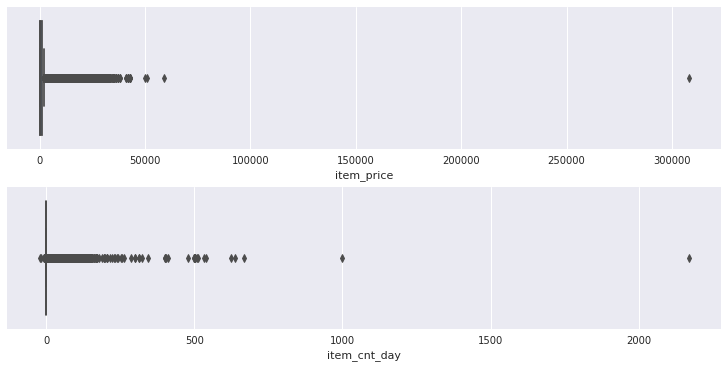

In [17]:
fig, axes = plt.subplots(2,1, figsize=(10,5), constrained_layout=True)

sns.boxplot(train_df['item_price'], ax=axes[0])

sns.boxplot(train_df['item_cnt_day'], ax=axes[1])

plt.show()

In [18]:
train = train_df.copy()
train.shape

(2935849, 6)

In [19]:
train = train.drop(train[train['item_price'] >= 45000].index)
train = train.drop(train[train['item_price'] < 0].index)

In [20]:
train['item_price'].sort_values()

579766         0.0700
608763         0.0700
611400         0.0875
673155         0.0900
601477         0.1000
              ...    
1006638    42000.0000
2885692    42990.0000
2917760    42990.0000
2931380    42990.0000
2910156    42990.0000
Name: item_price, Length: 2935844, dtype: float64

In [21]:
train[train['item_cnt_day'] < 0].value_counts()

date        date_block_num  shop_id  item_id  item_price  item_cnt_day
01.01.2013  0               18       6724     299.5       -1.0            1
20.10.2013  9               43       7802     299.0       -1.0            1
                                     3336     2499.0      -1.0            1
                                     3331     1199.0      -1.0            1
                            31       9186     299.0       -1.0            1
                                                                         ..
10.04.2013  3               32       3476     1199.0      -1.0            1
                            26       485      300.0       -1.0            1
                            22       7815     4152.0      -1.0            1
                                     5380     2966.0      -1.0            1
31.12.2014  23              54       1865     2999.0      -1.0            1
Length: 7356, dtype: int64

In [22]:
train['item_cnt_day'].sort_values().tail(20)

2626133     343.0
1573252     401.0
2067667     401.0
1501160     405.0
2067677     412.0
2625847     480.0
2909401     500.0
2257299     500.0
1708207     501.0
1573253     502.0
2864260     504.0
2067669     508.0
2048518     512.0
2851073     533.0
2626181     539.0
2608040     624.0
2851091     637.0
2864235     669.0
2326930    1000.0
2909818    2169.0
Name: item_cnt_day, dtype: float64

In [23]:
train = train.drop(train[train['item_cnt_day'] >= 600].index)
train = train.drop(train[train['item_cnt_day'] < 0].index)

In [24]:
print(train.shape)
print(train_df.shape)

(2928483, 6)
(2935849, 6)


In [29]:
train['date'] = pd.to_datetime(train['date'], dayfirst=True)
train['date'] = train['date'].apply(lambda x: x.strftime("%Y-%m"))

In [30]:
train.head().sort_values(by='date')
# train.sort_values(by='date').head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01,0,59,22154,999.00,1.0
1,2013-01,0,25,2552,899.00,1.0
3,2013-01,0,25,2554,1709.05,1.0
4,2013-01,0,25,2555,1099.00,1.0
5,2013-01,0,25,2564,349.00,1.0


In [31]:
train.drop(['date_block_num', 'item_price'], axis=1, inplace=True)

In [32]:
train.groupby(['date','shop_id','item_id']).sum()

item_cnt_day
date    shop_id item_id              
2013-01 0       32                6.0
                33                3.0
                35                1.0
                43                1.0
                51                2.0
...                               ...
2015-10 59      22087             6.0
                22088             2.0
                22091             1.0
                22100             1.0
                22102             1.0

[1608222 rows x 1 columns]

In [35]:
train = train.pivot_table(index=['shop_id', 'item_id'], columns='date', values='item_cnt_day', fill_value=0)
train

date             2013-01   2013-02  2013-03  2013-04  2013-05  2013-06  \
shop_id item_id                                                          
0       30           0.0  3.444444      0.0      0.0      0.0      0.0   
        31           0.0  1.571429      0.0      0.0      0.0      0.0   
        32           1.5  1.428571      0.0      0.0      0.0      0.0   
        33           1.0  1.000000      0.0      0.0      0.0      0.0   
        35           1.0  1.272727      0.0      0.0      0.0      0.0   
...                  ...       ...      ...      ...      ...      ...   
59      22154        1.0  0.000000      0.0      0.0      0.0      0.0   
        22155        0.0  0.000000      0.0      0.0      0.0      0.0   
        22162        0.0  0.000000      0.0      0.0      0.0      0.0   
        22164        0.0  0.000000      0.0      0.0      0.0      0.0   
        22167        0.0  0.000000      0.0      0.0      0.0      0.0   

date             2013-07  2013-08  2013-09  2013-10  ...  2015-01  2015-02  \
shop_id item_id                                      ...                     
0       30           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        31           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        32           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        33           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        35           0.0      0.0      0.0      0.0  ...      0.0      0.0   
...                  ...      ...      ...      ...  ...      ...      ...   
59      22154        0.0      0.0      0.0      0.0  ...      0.0      0.0   
        22155        1.0      0.0      0.0      0.0  ...      0.0      0.0   
        22162        0.0      0.0      0.0      0.0  ...      0.0      1.0   
        22164        0.0      0.0      0.0      0.0  ...      0.0      1.0   
        22167        0.0      0.0      0.0      1.0  ...      0.0      0.0   

date             2015-03  2015-04  2015-05  2015-06  2015-07  2015-08  \
shop_id item_id                                                         
0       30           0.0      0.0      0.0      0.0      0.0      0.0   
        31           0.0      0.0      0.0      0.0      0.0      0.0   
        32           0.0      0.0      0.0      0.0      0.0      0.0   
        33           0.0      0.0      0.0      0.0      0.0      0.0   
        35           0.0      0.0      0.0      0.0      0.0      0.0   
...                  ...      ...      ...      ...      ...      ...   
59      22154        0.0      0.0      0.0      0.0      0.0      0.0   
        22155        0.0      0.0      0.0      0.0      0.0      0.0   
        22162        1.0      1.0      1.0      0.0      0.0      1.0   
        22164        1.0      1.0      0.0      0.0      1.0      0.0   
        22167        0.0      0.0      0.0      0.0      0.0      0.0   

date             2015-09  2015-10  
shop_id item_id                    
0       30           0.0      0.0  
        31           0.0      0.0  
        32           0.0      0.0  
        33           0.0      0.0  
        35           0.0      0.0  
...                  ...      ...  
59      22154        0.0      0.0  
        22155        0.0      0.0  
        22162        0.0      0.0  
        22164        0.0      0.0  
        22167        0.0      0.0  

[424095 rows x 34 columns]

In [36]:
train.reset_index(inplace=True)
train

date,shop_id,item_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,0,30,0.0,3.444444,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,0.0,1.571429,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,1.5,1.428571,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,1.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,1.0,1.272727,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424090,59,22154,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
424091,59,22155,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
424092,59,22162,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
424093,59,22164,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [40]:
df = pd.merge(test_df, train, on=['shop_id','item_id'], how='left')
df

,ID,shop_id,item_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
1,1,5,5320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.5,1.0,0.0,1.0,1.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
214196,214196,45,16188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214197,214197,45,15757,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214198,214198,45,19648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
df.drop(['ID'], axis=1, inplace=True)
df = df.fillna(0)
df

,shop_id,item_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.5,1.0,0.0,1.0,1.0,1.0
3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,45,18454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
214196,45,16188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214197,45,15757,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214198,45,19648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
df.drop(['2013-01'], axis=1, inplace=True)

In [46]:
y_train = train['2015-10'].values
X_train = train.drop(['2015-10'], axis=1)
X_test = df

print(X_train.shape, y_train.shape)
print(X_test.shape)

(424095, 35) (424095,)
(214200, 35)


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [57]:
rf = RandomForestRegressor(n_estimators=50, max_depth=20, random_state=0, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=50, n_jobs=-1, random_state=0)

In [58]:
train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)

print('Train MSE:', mean_squared_error(y_train, train_pred))
print('Test MSE:', mean_squared_error(y_test, test_pred))
print('Test SCORE:', rf.score(X_train, y_train))

Train MSE: 0.07534920420883066
Test MSE: 3.060906939905621
Test SCORE: 0.42707689709007257
